In [3]:
# !pip install missingno

### Libraries

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import missingno as msno
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
import warnings
warnings.filterwarnings('ignore')

# style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

### Load the data

In [13]:
df = pd.read_csv("cleaned_data/df_processed.csv")
df_copy = df.copy()

### Subset the dataframe

In [14]:
df = df[[
    'individual_id','age', 'bmi'
    , 'hiv_status_derived', 'hiv_status_derived_age', 'hpt_status_derived', 'hpt_status_derived_age', 'diab_status_derived', 'diab_status_derived_age',
    'obese_status_derived', 'tb_status_derived'
    ,'stroke_status_derived', 'stroke_status_derived_age'
]]

In [22]:
# Basic information
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

print("\nData Types:")
print(df.dtypes)

print("\nBasic Statistics:")
print(df.describe())

Dataset Shape: (46769, 13)

First 5 rows:
                          individual_id  age      bmi  hiv_status_derived  \
0  000025C5-5811-4942-8957-8A1A4FF1460F   35      NaN                   0   
1  000025C5-5811-4942-8957-8A1A4FF1460F   39  25.9187                   0   
2  0004A623-93CA-4D53-B10C-805B27EFD98F   36  31.1690                   0   
3  000D523D-F549-40B3-B8E1-2FF517084EB0   56      NaN                   0   
4  000D523D-F549-40B3-B8E1-2FF517084EB0   61  32.6677                   0   

   hiv_status_derived_age  hpt_status_derived  hpt_status_derived_age  \
0                    35.0                   0                    35.0   
1                    39.0                   1                    39.0   
2                    36.0                   1                    36.0   
3                    56.0                   1                    56.0   
4                    61.0                   1                    56.0   

   diab_status_derived  diab_status_derived_age  obese_s

### Comprehensive Missingness Analysis

In [23]:
def comprehensive_missingness_analysis(df):
    """Comprehensive missing value analysis"""
    
    print("="*50)
    print("COMPREHENSIVE MISSINGNESS ANALYSIS")
    print("="*50)
    
    # 1. Overall missingness
    total_missing = df.isnull().sum().sum()
    total_cells = df.size
    missing_percentage = (total_missing / total_cells) * 100
    
    print(f"Total missing values: {total_missing}")
    print(f"Percentage of missing data: {missing_percentage:.2f}%")
    
    # 2. Missing values by column
    missing_by_column = df.isnull().sum()
    missing_percentage_by_column = (missing_by_column / len(df)) * 100
    
    print("\nMissing values by column:")
    missing_info = pd.DataFrame({
        'Missing_Count': missing_by_column,
        'Missing_Percentage': missing_percentage_by_column,
        'Data_Type': df.dtypes
    })
    missing_info = missing_info[missing_info['Missing_Count'] > 0]
    
    if len(missing_info) > 0:
        print(missing_info.sort_values('Missing_Percentage', ascending=False))
    else:
        print("No missing values found in any column!")
    
    return missing_info

# Analysis
missing_info = comprehensive_missingness_analysis(df)

COMPREHENSIVE MISSINGNESS ANALYSIS
Total missing values: 52082
Percentage of missing data: 8.57%

Missing values by column:
                      Missing_Count  Missing_Percentage Data_Type
tb_status_derived             24072           51.469991   float64
bmi                           17310           37.011696   float64
obese_status_derived          10700           22.878402   float64


### Visualize Missing Data Patterns

<Figure size 1200x600 with 0 Axes>

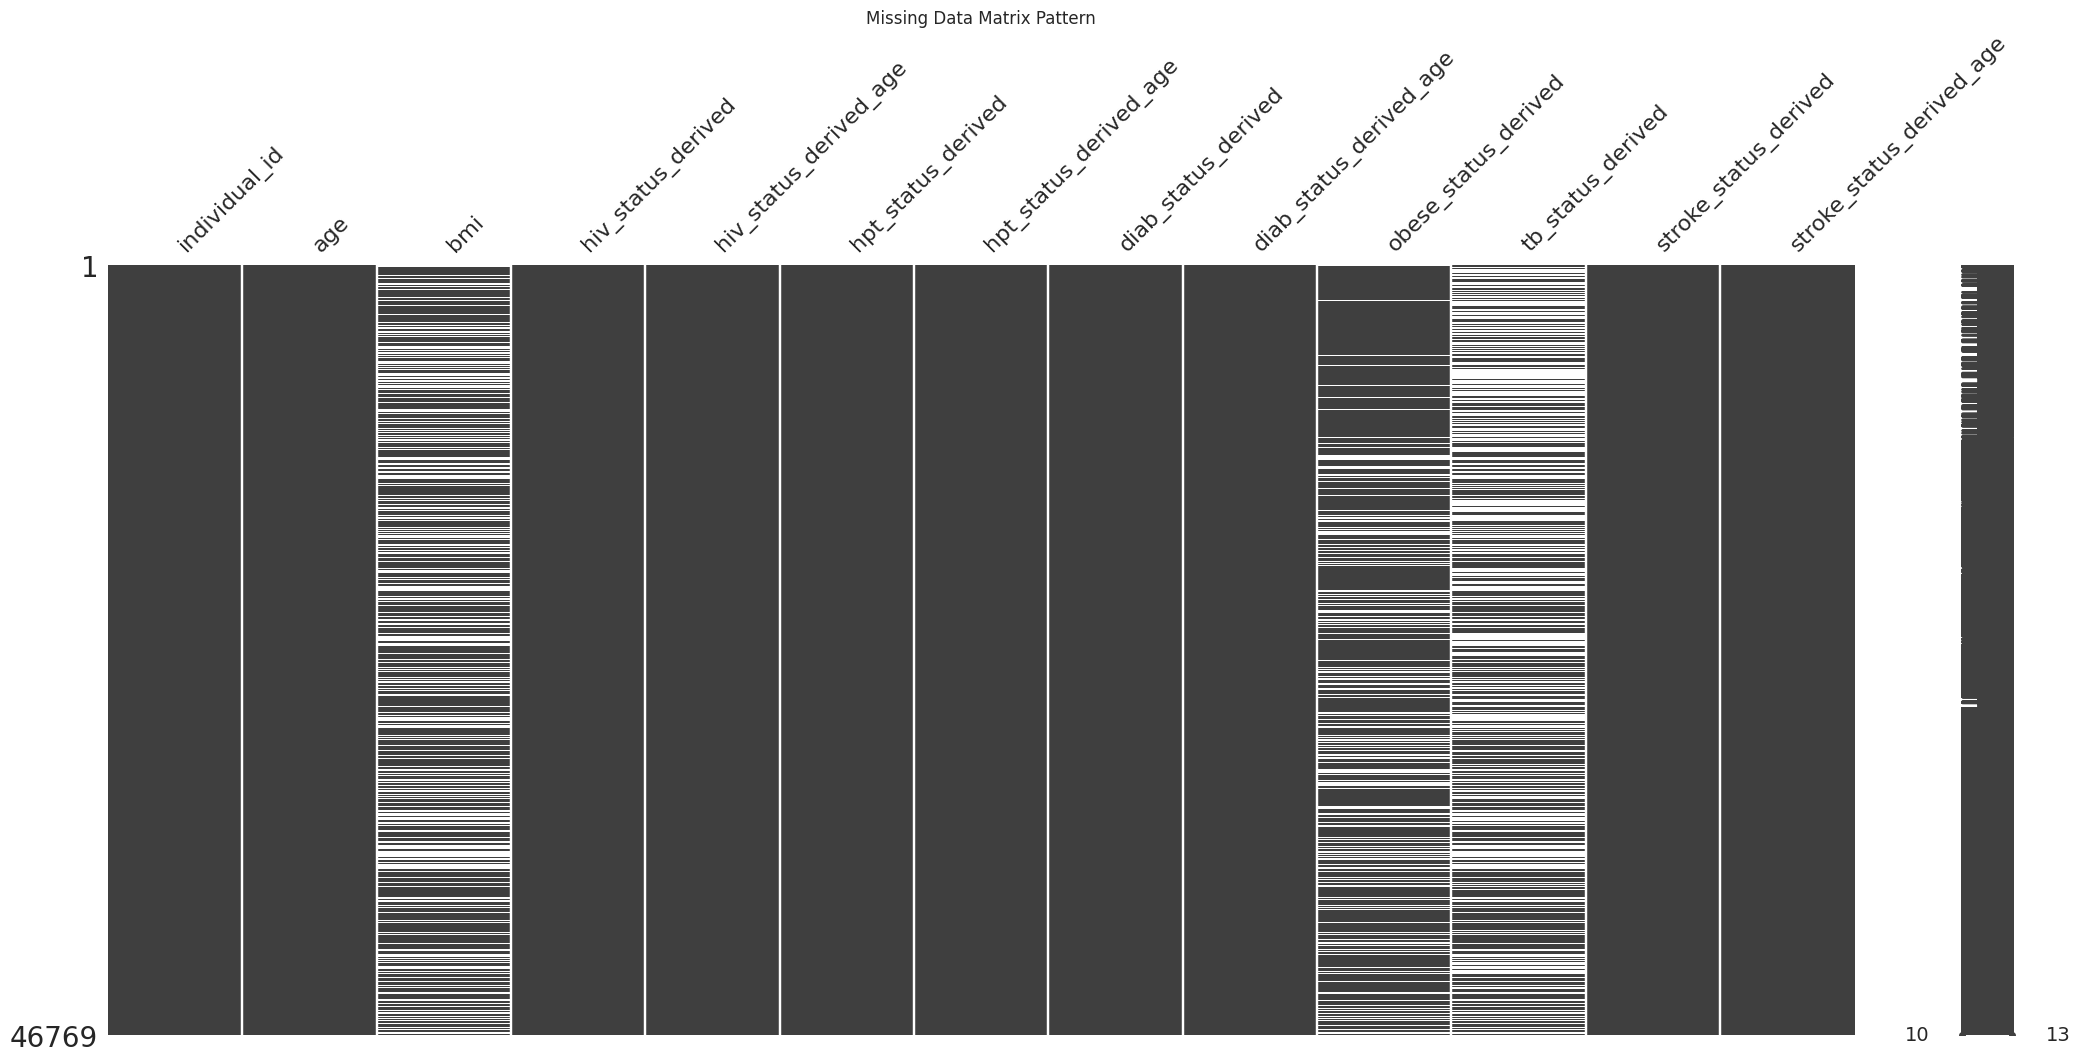

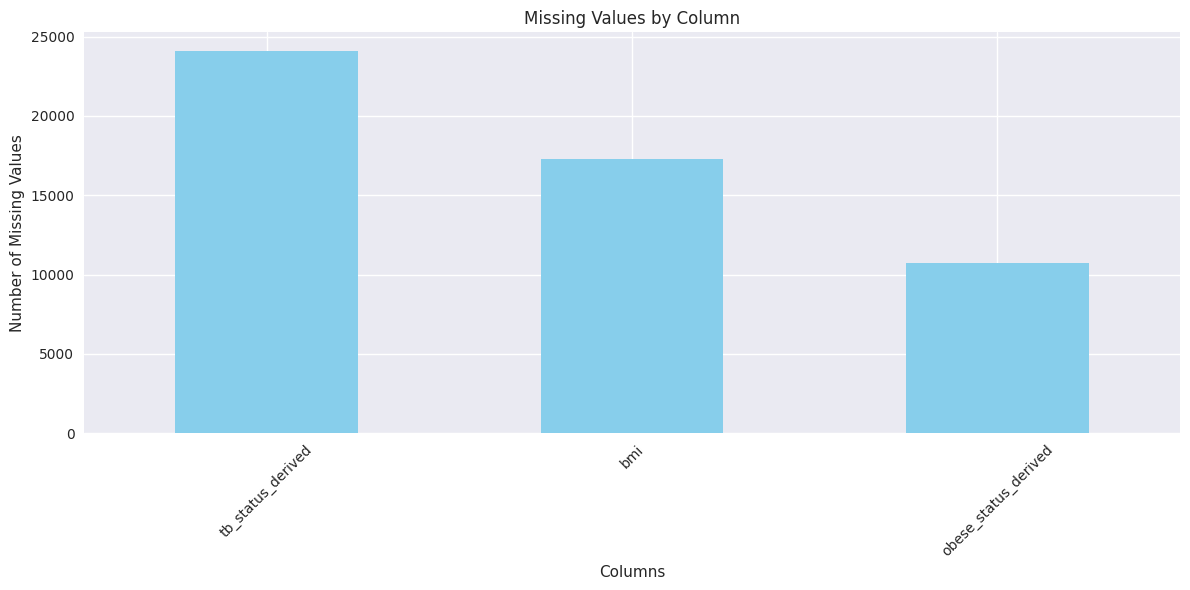

<Figure size 1000x800 with 0 Axes>

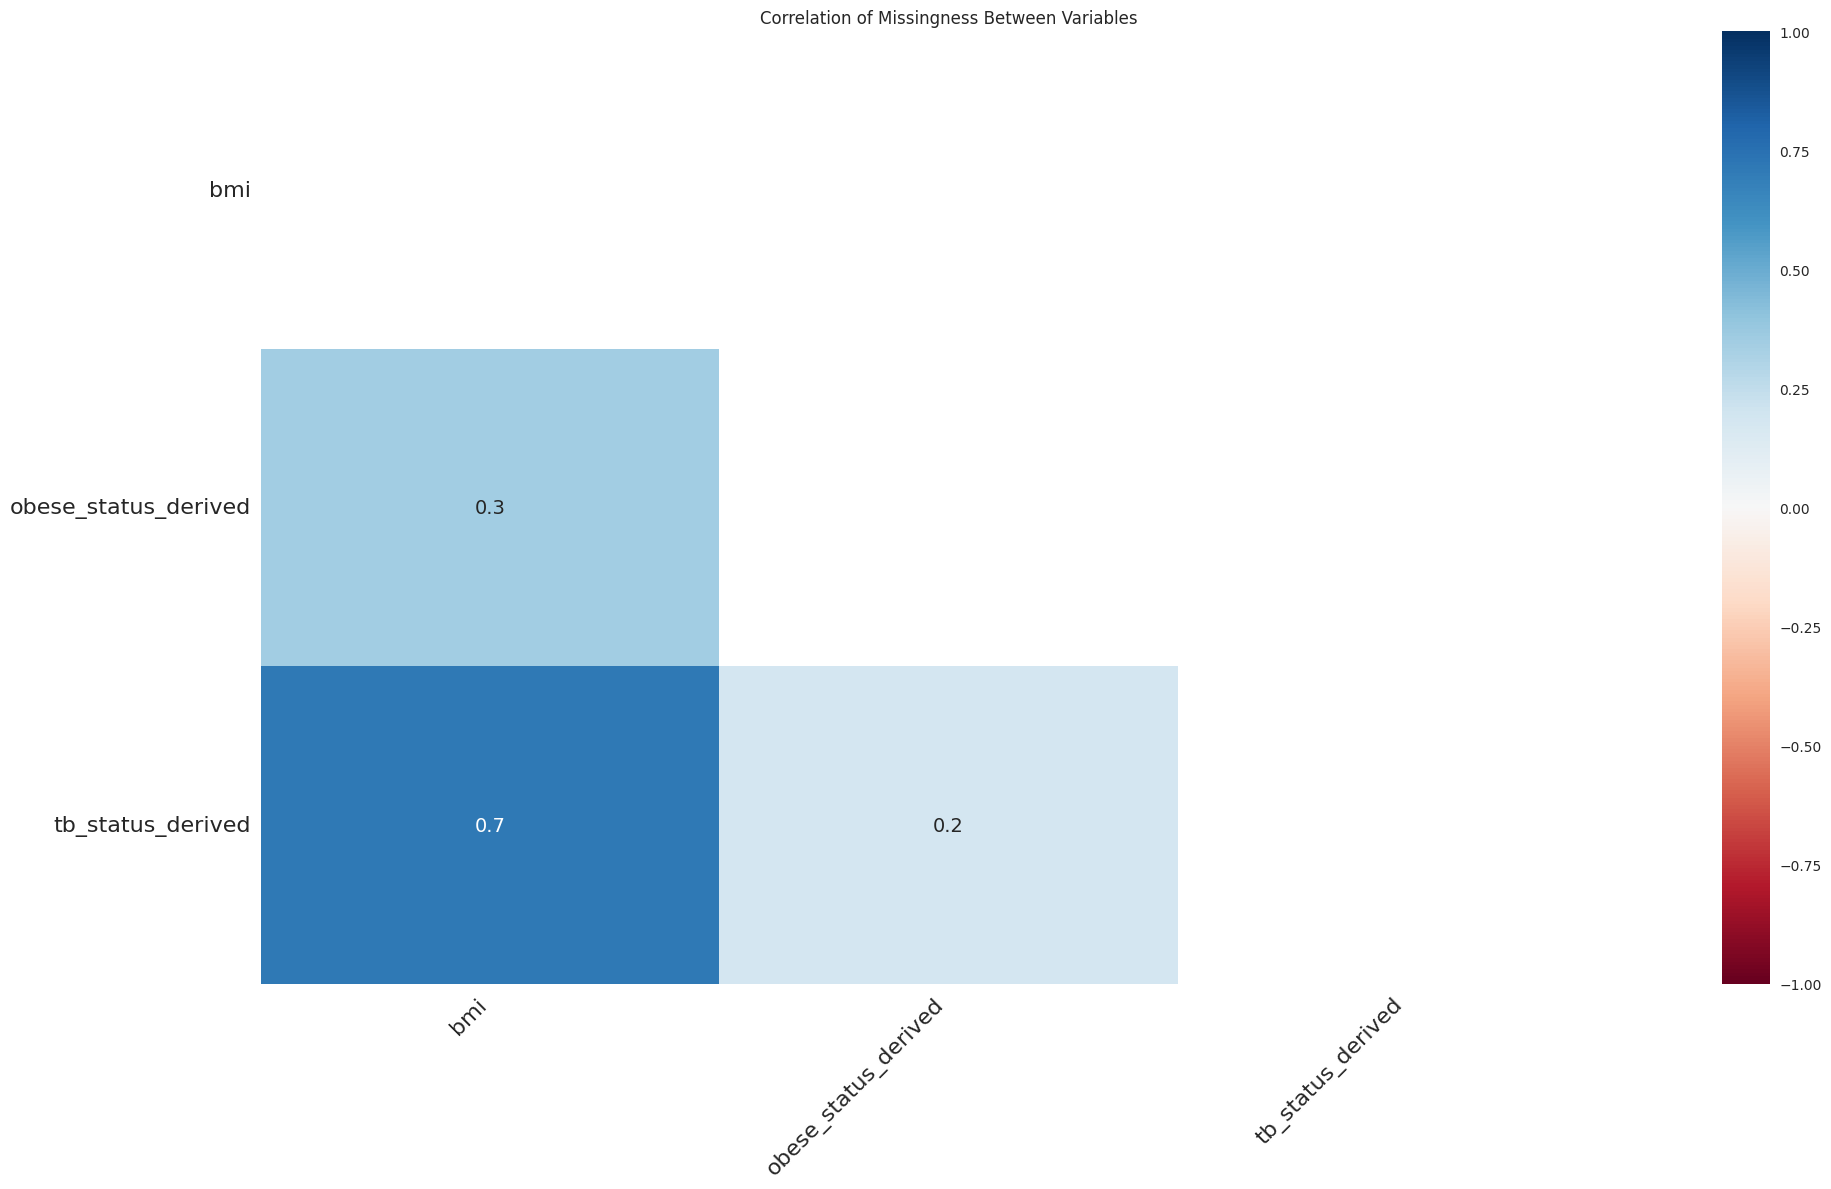

<Figure size 1200x600 with 0 Axes>

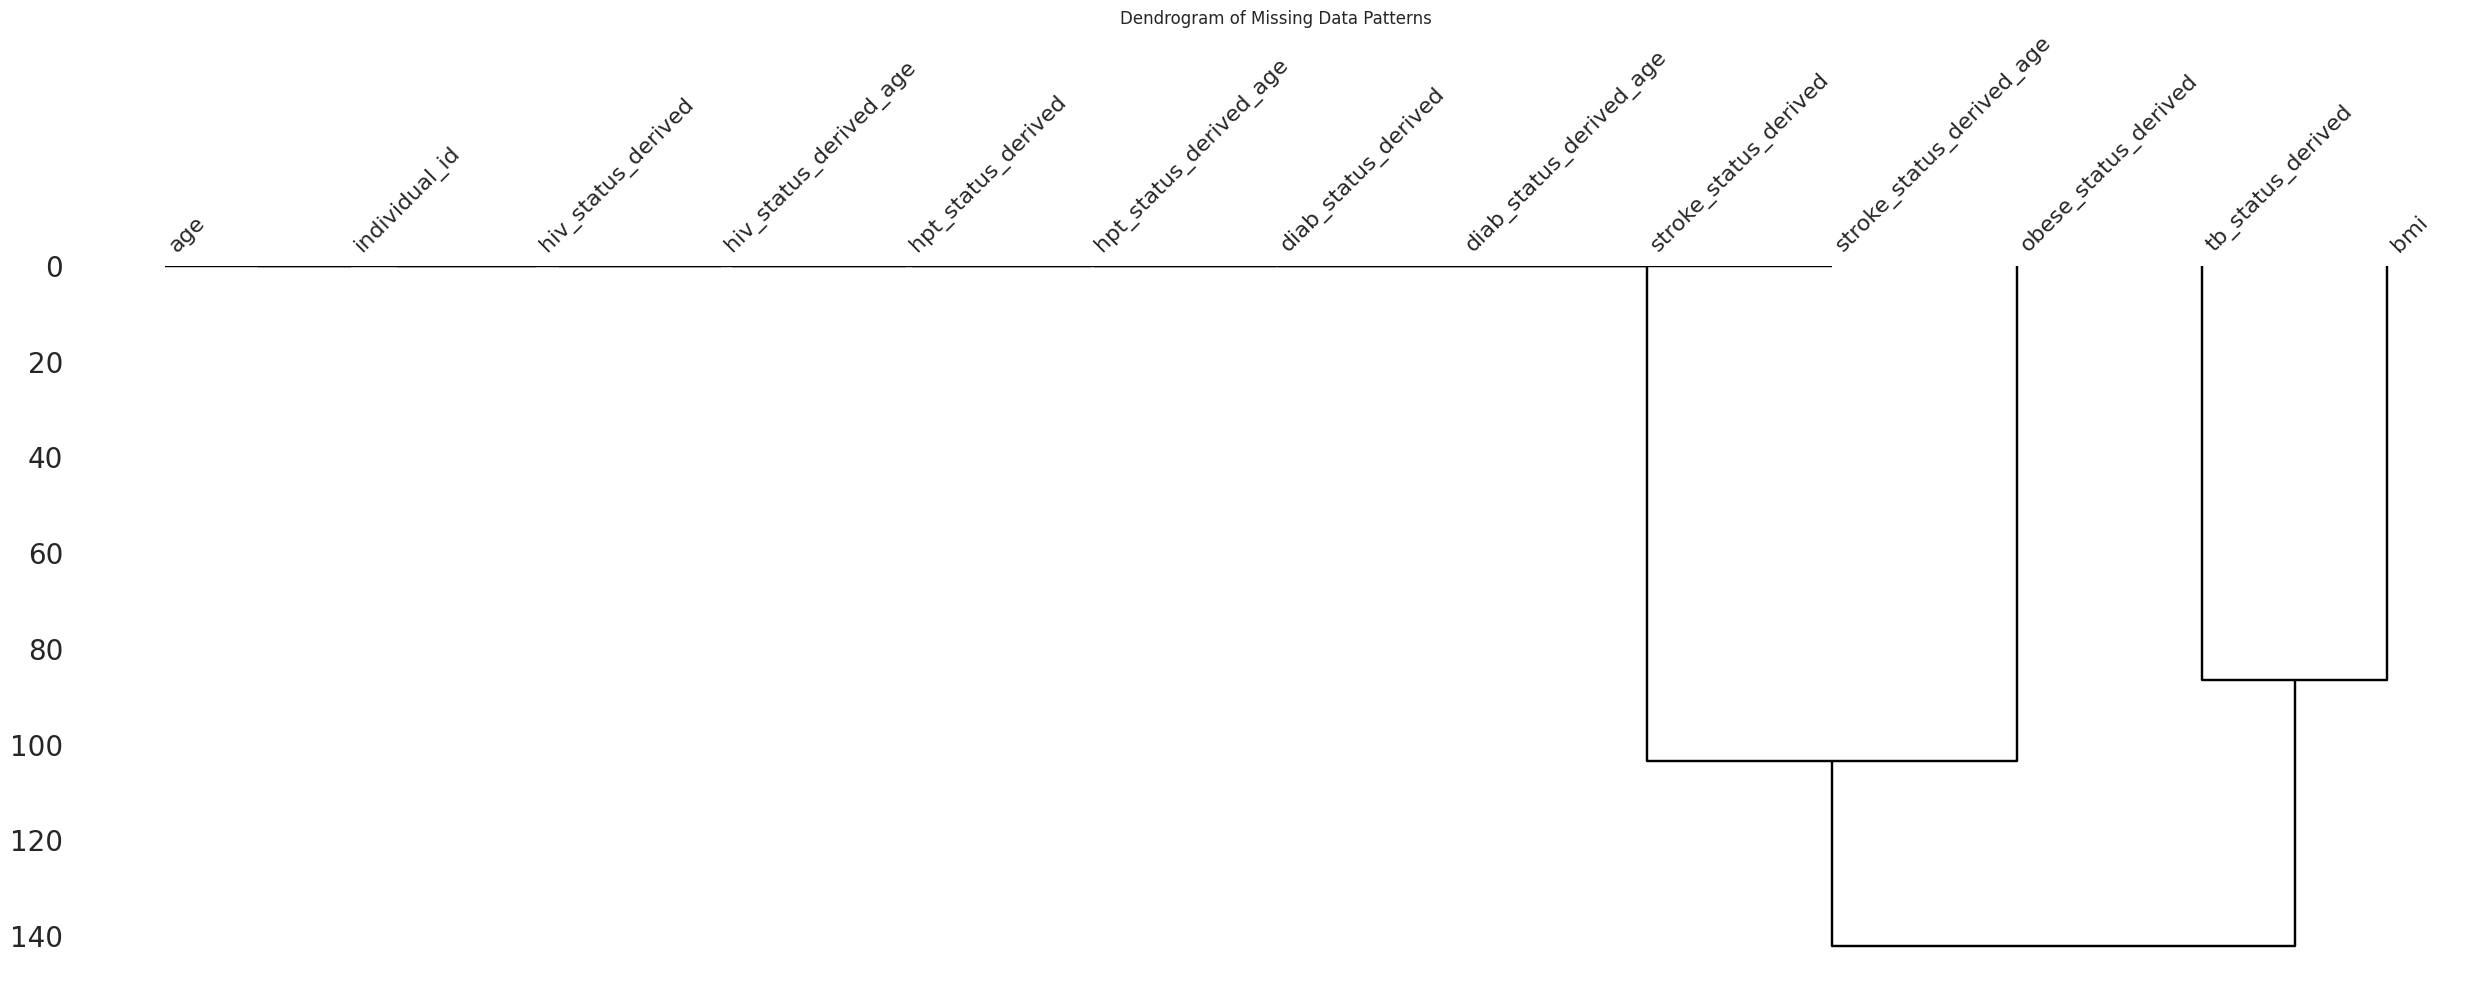

In [17]:
def visualize_missingness(df):
    """Visualizations for missing data patterns"""
    
    # 1. Matrix plot
    plt.figure(figsize=(12, 6))
    msno.matrix(df)
    plt.title('Missing Data Matrix Pattern')
    plt.tight_layout()
    plt.show()
    
    # 2. Bar plot of missing values
    plt.figure(figsize=(12, 6))
    missing_counts = df.isnull().sum().sort_values(ascending=False)
    missing_counts = missing_counts[missing_counts > 0]
    
    if len(missing_counts) > 0:
        missing_counts.plot(kind='bar', color='skyblue')
        plt.title('Missing Values by Column')
        plt.xlabel('Columns')
        plt.ylabel('Number of Missing Values')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    # 3. Heatmap of missing data correlation
    plt.figure(figsize=(10, 8))
    msno.heatmap(df)
    plt.title('Correlation of Missingness Between Variables')
    plt.tight_layout()
    plt.show()
    
    # 4. Dendrogram for missing data patterns
    plt.figure(figsize=(12, 6))
    msno.dendrogram(df)
    plt.title('Dendrogram of Missing Data Patterns')
    plt.tight_layout()
    plt.show()

visualize_missingness(df)

### Analyze Missing Data Mechanisms

In [18]:
def analyze_missing_mechanisms(df, target_column='stroke'):
    """Is missingness related to other variables"""
    
    print("="*50)
    print("MISSING DATA MECHANISM ANALYSIS")
    print("="*50)
    
    # Check if missingness is related to target variable (stroke)
    for column in df.columns:
        if df[column].isnull().sum() > 0:
            # Indicator for missing values
            missing_indicator = df[column].isnull().astype(int)
            
            if target_column in df.columns:
                # Comparing target distribution between missing and non-missing
                non_missing_target = df.loc[~df[column].isnull(), target_column]
                missing_target = df.loc[df[column].isnull(), target_column]
                
                if len(missing_target) > 0 and len(non_missing_target) > 0:
                    # T-test for continuous target, chi-square for categorical
                    if df[target_column].dtype in ['int64', 'float64']:
                        t_stat, p_value = stats.ttest_ind(
                            non_missing_target.dropna(),
                            missing_target.dropna(),
                            equal_var=False
                        )
                        print(f"{column}: t-stat={t_stat:.3f}, p-value={p_value:.3f}")
                    else:
                        # Chi-square test (for categorical target) 
                        contingency_table = pd.crosstab(missing_indicator, df[target_column])
                        chi2, p_value, _, _ = stats.chi2_contingency(contingency_table)
                        print(f"{column}: chi2={chi2:.3f}, p-value={p_value:.3f}")
            
            # Correlation with other variables
            print(f"\nCorrelation of missingness in {column} with other variables:")
            for other_col in df.columns:
                if other_col != column and df[other_col].dtype in ['int64', 'float64']:
                    correlation = df[other_col].corr(missing_indicator)
                    if not pd.isna(correlation) and abs(correlation) > 0.1:
                        print(f"  {other_col}: correlation={correlation:.3f}")

analyze_missing_mechanisms(df)

MISSING DATA MECHANISM ANALYSIS

Correlation of missingness in bmi with other variables:
  age: correlation=-0.211
  hiv_status_derived: correlation=-0.200
  hiv_status_derived_age: correlation=-0.194
  hpt_status_derived_age: correlation=-0.159
  diab_status_derived_age: correlation=-0.204
  obese_status_derived: correlation=-0.197
  stroke_status_derived_age: correlation=-0.209

Correlation of missingness in obese_status_derived with other variables:
  age: correlation=0.110
  bmi: correlation=-0.897
  hiv_status_derived: correlation=0.100
  hiv_status_derived_age: correlation=0.112
  hpt_status_derived: correlation=0.229
  hpt_status_derived_age: correlation=0.124
  diab_status_derived: correlation=0.231
  diab_status_derived_age: correlation=0.112
  tb_status_derived: correlation=0.129
  stroke_status_derived_age: correlation=0.110

Correlation of missingness in tb_status_derived with other variables:
  age: correlation=-0.341
  hiv_status_derived: correlation=-0.120
  hiv_status_d

### Advanced Missingness Analysis for Stroke Data

In [19]:
def stroke_specific_missingness_analysis(df):
    """Stroke-specific missingness analysis"""
    
    # Analyze missingness patterns by stroke status
    if 'stroke' in df.columns:
        print("Missingness patterns by stroke status:")
        
        stroke_missing = df[df['stroke'] == 1].isnull().mean() * 100
        no_stroke_missing = df[df['stroke'] == 0].isnull().mean() * 100
        
        missing_comparison = pd.DataFrame({
            'Stroke_Patients_Missing': stroke_missing,
            'Non_Stroke_Patients_Missing': no_stroke_missing,
            'Difference': stroke_missing - no_stroke_missing
        })
        
        # Filtering columns with meaningful differences
        meaningful_diff = missing_comparison[
            (abs(missing_comparison['Difference']) > 2) & 
            ((stroke_missing > 5) | (no_stroke_missing > 5))
        ]
        
        if len(meaningful_diff) > 0:
            print("Significant differences in missingness patterns:")
            print(meaningful_diff.sort_values('Difference', ascending=False))
        else:
            print("No significant differences in missingness patterns between stroke and non-stroke patients")

stroke_specific_missingness_analysis(df)

### Generate Missingness Report

In [20]:
def generate_missingness_report(df):
    """Comprehensive missingness report"""
    
    report = {
        'total_rows': len(df),
        'total_columns': len(df.columns),
        'total_missing_values': df.isnull().sum().sum(),
        'overall_missing_percentage': (df.isnull().sum().sum() / df.size) * 100,
        'columns_with_missing': [],
        'missingness_patterns': {}
    }
    
    # Analyzing columns with missing values
    for column in df.columns:
        missing_count = df[column].isnull().sum()
        if missing_count > 0:
            column_info = {
                'column_name': column,
                'data_type': str(df[column].dtype),
                'missing_count': missing_count,
                'missing_percentage': (missing_count / len(df)) * 100,
                'unique_values': df[column].nunique() if df[column].dtype == 'object' else None
            }
            report['columns_with_missing'].append(column_info)
    
    # Saving the report
    report_df = pd.DataFrame(report['columns_with_missing'])
    if len(report_df) > 0:
        report_df.to_csv('stroke_output/missingness_report.csv', index=False)
        print("Missingness report saved to 'missingness_report.csv'")
    
    return report

# Generating & displaying results
missingness_report = generate_missingness_report(df)
print("\nMissingness Report Summary:")
print(f"Total rows: {missingness_report['total_rows']}")
print(f"Total missing values: {missingness_report['total_missing_values']}")
print(f"Overall missing percentage: {missingness_report['overall_missing_percentage']:.2f}%")

Missingness report saved to 'missingness_report.csv'

Missingness Report Summary:
Total rows: 46769
Total missing values: 52082
Overall missing percentage: 8.57%
